In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm


class VectorReconstruction(nn.Module):
    def __init__(self, in_dim=1, hidden_dim=16, out_dim=1) -> None:
        super().__init__()
        self.model = nn.Sequential(
                nn.Linear(in_dim,hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim,out_dim),)

    def forward(self, x):
        x = self.model(x)
        return torch.atan2(torch.sin(x), torch.cos(x))

# Hyperparameters
epochs = 100

def vonMisesLoss(output, target):
    return torch.sum(1 - torch.exp(torch.cos(output - target))) 


In [3]:
class CustomDataset(Dataset):
    def __init__(self):
        # Utility function to ensure angle values are bound between [-pi, pi]
        def adjust_angles(angles):
            angles = angles % (2 * np.pi)
            angles[angles > np.pi] -= 2 * np.pi
            return angles

        # 1. Original linear data from [0, 10] mapped to [-pi, pi]
        linear_data = torch.linspace(0, 10, steps=32 * 128).view(-1, 1)
        linear_labels = adjust_angles(linear_data / 10 * 2 * np.pi)

        # 2. Boundary data: 4096 cases between 9.8 and 10.2
        boundary_data = torch.linspace(9.8, 10.2, steps=4096).view(-1, 1)
        boundary_labels = adjust_angles(boundary_data / 10 * 2 * np.pi)
        
        # 3. Shifted linear data: [-pi/2, 3*pi/2]
        shifted_data = torch.linspace(-5, 15, steps=32 * 128).view(-1, 1)
        shifted_labels = adjust_angles(shifted_data / 10 * 2 * np.pi)

        # # 4. Noisy wrapping: Add noise, especially near the boundaries
        # noise = torch.normal(mean=0.0, std=0.1, size=linear_labels.size())
        # noisy_labels = adjust_angles(linear_labels + noise)

        # 5. Random sampling with wrapping
        random_data = torch.rand(size=(32 * 128, 1)) * 15
        random_labels = adjust_angles(random_data / 15 * 2 * np.pi)

        # Concatenate all data and labels to form the complete dataset
        self.data = torch.cat([linear_data, boundary_data, shifted_data, random_data], dim=0).float()
        self.labels = torch.cat([linear_labels, boundary_labels, shifted_labels, random_labels], dim=0).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Test the CustomDataset and print a sample
dataset = CustomDataset()

train_set, test_set  = random_split(dataset, [0.8,0.2])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
batch = next(iter(train_loader))

df = pd.DataFrame({'Data': batch[0].numpy().flatten(), 'Labels': batch[1].numpy().flatten()})
print(df)




         Data    Labels
0    0.929604  0.389392
1    7.869366 -2.986873
2    1.914530  1.202935
3   10.189255  0.118912
4    9.961759 -0.024028
5    9.970159 -0.018750
6   10.042735  0.026851
7   14.054955 -0.395860
8    7.019536 -1.872681
9   14.807203 -0.080758
10   0.170940  0.107405
11  10.100268  0.063000
12   4.724054  2.968211
13   3.590965  2.256270
14   1.027630  0.430453
15  11.656830 -1.400384
16  12.411477  1.515176
17   9.516483 -0.303802
18   8.800892 -2.596676
19  -3.075702 -1.932520
20  10.068718  0.043177
21   9.310134 -0.433455
22  12.836386  1.782154
23  10.170110  0.106883
24   8.212454 -1.123148
25  11.478632  0.929051
26   3.002620  1.257735
27  10.079268  0.049805
28  -0.643467 -0.404303
29   9.949450 -0.031761
30   6.238095 -2.363675
31  14.160789 -0.351528


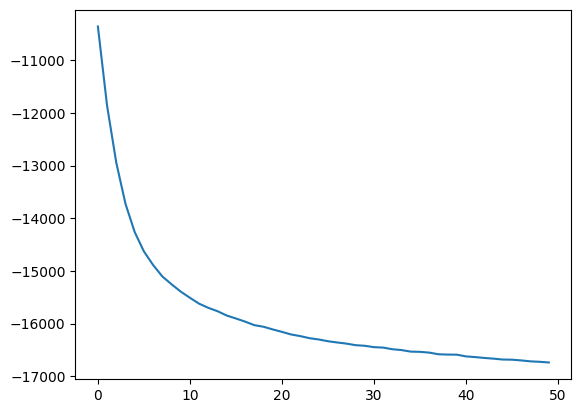

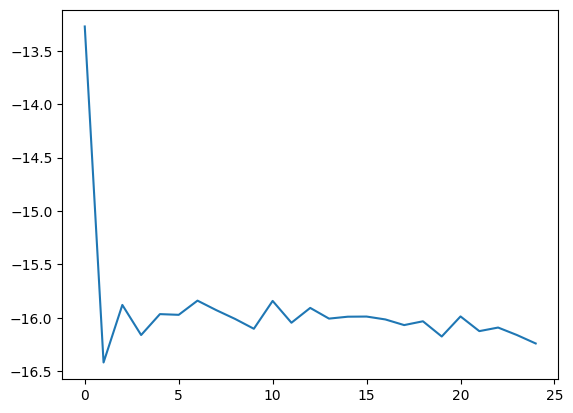

In [5]:
# Hyperparameters
epochs = 50
learning_rate = 1e-3

# Loss and optimizer
device = 'cpu'
model = VectorReconstruction().to(device)
criterion = vonMisesLoss
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
loop = tqdm(range(epochs), total=epochs, leave=False)
training_losses = []
test_losses = []

for epoch in loop:
    model.train()
    epoch_loss = 0
    for data, target in train_loader:
        # Description
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        
        data = data.to(device)
        target = target.to(device)

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    training_losses.append(epoch_loss)

    with torch.no_grad():
        # testing the model
        model.eval()
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)

        if epoch % 2 == 0:
            test_losses.append(loss.item())



plt.plot([x for x in range(len(training_losses))], training_losses)
plt.show()

plt.plot([x for x in range(len(test_losses))], test_losses)
plt.show()

     Test Vector  Test Output
0     -50.000000     1.411816
1     -49.497486     1.709221
2     -48.994976     2.006627
3     -48.492462     2.304036
4     -47.989948     2.601449
..           ...          ...
195    47.989948     0.020064
196    48.492462    -0.061879
197    48.994976    -0.143822
198    49.497486    -0.225765
199    50.000000    -0.307707

[200 rows x 2 columns]


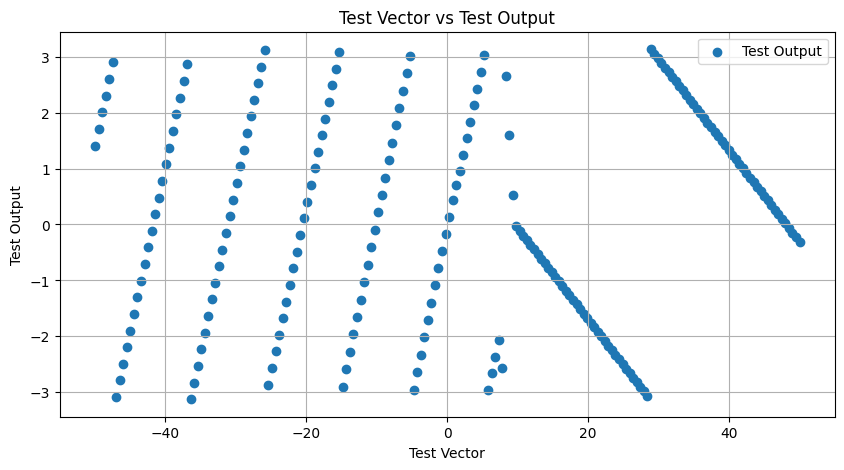

In [6]:
model.eval()

test_vec = torch.linspace(-50, 50, steps=200).view(-1, 1)

with torch.no_grad():
    test_output = model(test_vec)
    # Create a dataframe from test_vec and test_output
    df_test = pd.DataFrame({'Test Vector': test_vec.numpy().flatten(), 'Test Output': test_output.numpy().flatten()})
    print(df_test)

    # Plotting the test vector and test output
    plt.figure(figsize=(10, 5))
    plt.scatter(df_test['Test Vector'], df_test['Test Output'], label='Test Output')
    plt.xlabel('Test Vector')
    plt.ylabel('Test Output')
    plt.title('Test Vector vs Test Output')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Test 2: Real data, single image
from src.dataset import ds

In [ ]:
item = ds.__getitem__(4)
phase = torch.angle(item[0])[0]

import torchaudio
mag = torchaudio.transforms.AmplitudeToDB()(torch.abs(item[0])[0])


In [ ]:
print(plt.imshow(mag))

In [ ]:
# Hyperparameters
epochs = 5000
learning_rate = 3e-4

# Loss and optimizer
device = 'cpu'
model = VectorReconstruction(in_dim=94, hidden_dim=512, out_dim=94).to(device)
criterion = vonMisesLoss

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
loop = tqdm(range(epochs), total=epochs, leave=False)
training_losses = []
test_losses = []

# Model Dim test
t = torch.randn(513, 94)
assert model(t).shape == t.shape


for epoch in loop:
    model.train()
    epoch_loss = 0

    # Description
    loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
    
    mag = torch.abs(item[0])[0]
    target = torch.angle(item[0])[0]

    # Forward pass
    output = model(mag)
    loss = criterion(output, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    training_losses.append(epoch_loss)


plt.plot([x for x in range(len(training_losses))], training_losses)
plt.show()


In [ ]:
# Create a new figure with a specific size
plt.figure(figsize=(10, 5))  # You can adjust the values (10, 5) to stretch the display as needed

# Display the tensor
plt.imshow(phase, aspect='auto') # aspect='auto' allows the image to fill the figure, stretching it.

# Other possible plot decorations (titles, labels, etc.)
plt.title('Phase')
plt.colorbar()  # If you want to show the color scale
plt.ylabel('Frequency Bins')
plt.xlabel('Time Bins')

# Finally, show the plot
plt.show()

plt.figure(figsize=(10, 5))  # You can adjust the values (10, 5) to stretch the display as needed
plt.imshow(model(mag).detach(), aspect='auto') # aspect='auto' allows the image to fill the figure, stretching it.

# Other possible plot decorations (titles, labels, etc.)
plt.title('Model output')
plt.colorbar()  # If you want to show the color scale
plt.ylabel('Frequency Bins')
plt.xlabel('Time Bins')

# Finally, show the plot
plt.show()